In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [14]:
# Load and preprocess data
url = '/kaggle/input/eng-french/eng_-french.csv' 
data = pd.read_csv(url)
data.rename(columns={"English words/sentences": "Eng", "French words/sentences": "Frn"}, inplace=True)


In [15]:
def tokenize_and_pad(texts, max_len=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded_sequences, tokenizer

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'])
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'])

eng_max_len = max(len(seq) for seq in eng_sequences)
frn_max_len = max(len(seq) for seq in frn_sequences)

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'], max_len=eng_max_len)
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'], max_len=frn_max_len)

eng_vocab_size = len(eng_tokenizer.word_index) + 1
frn_vocab_size = len(frn_tokenizer.word_index) + 1

train_eng, test_eng, train_frn, test_frn = train_test_split(eng_sequences, frn_sequences, test_size=0.2, random_state=42)



In [18]:
def define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim=128, lstm_units=256):
    # Encoder
    encoder_inputs = Input(shape=(eng_max_len,))
    encoder_embedding = Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_len, mask_zero=True)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(lstm_units, return_sequences=False))(encoder_embedding)
    
    # Repeat the encoder output for the decoder
    decoder_inputs = RepeatVector(frn_max_len)(encoder_lstm)
    
    # Decoder
    decoder_lstm = LSTM(lstm_units*2, return_sequences=True)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units*2, return_sequences=True)(decoder_lstm)
    decoder_dense = TimeDistributed(Dense(frn_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_lstm)

    # Define the model
    model = Model(encoder_inputs, decoder_outputs)
    
    # Compile the model
    initial_learning_rate = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.5,
        staircase=True
    )
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



Epoch 1/15

440/440 [==============================] - 170s 362ms/step - loss: 9.2207 - accuracy: 0.1489 - val_loss: 7.6057 - val_accuracy: 0.1493

Epoch 2/15

440/440 [==============================] - 165s 375ms/step - loss: 6.9062 - accuracy: 0.1560 - val_loss: 6.5184 - val_accuracy: 0.1625

Epoch 3/15

440/440 [==============================] - 145s 329ms/step - loss: 6.3819 - accuracy: 0.1731 - val_loss: 6.2968 - val_accuracy: 0.1714

Epoch 4/15

440/440 [==============================] - 164s 372ms/step - loss: 6.2367 - accuracy: 0.1754 - val_loss: 6.2103 - val_accuracy: 0.1753

Epoch 5/15

440/440 [==============================] - 164s 374ms/step - loss: 6.1637 - accuracy: 0.1776 - val_loss: 6.1572 - val_accuracy: 0.1784

Epoch 6/15

440/440 [==============================] - 145s 329ms/step - loss: 6.1179 - accuracy: 0.1796 - val_loss: 6.1084 - val_accuracy: 0.1790

Epoch 7/15

440/440 [==============================] - 164s 373ms/step - loss: 6.0852 - accuracy: 0.1801 - val_l

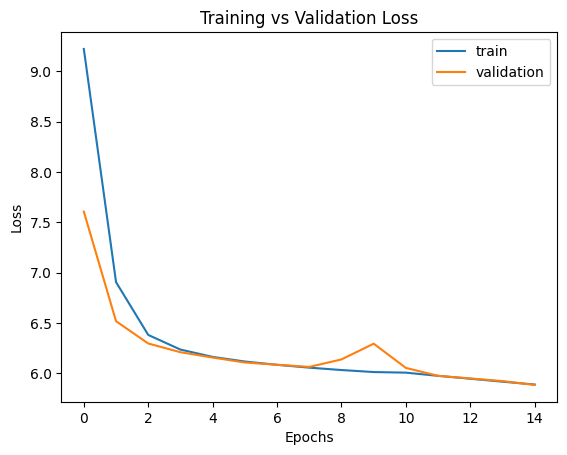

In [31]:
embedding_dim = 128
lstm_units = 256
batch_size = 256
epochs = 15

model = define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim, lstm_units)

# Prepare data for the decoder
train_frn_input = train_frn[:, :-1]  # input 
train_frn_output = train_frn[:, 1:]  # expected output 

# Padding train_frn_input to ensure it matches the required input shape
train_frn_input = pad_sequences(train_frn_input, maxlen=frn_max_len, padding='post')
train_frn_output = pad_sequences(train_frn_output, maxlen=frn_max_len, padding='post')

# Train the model
history = model.fit(train_eng, train_frn_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

plt.show()


In [38]:
import random


In [39]:
def decode_sequence(input_seq):
    # Predict the encoder's state
    states_value = encoder_model.predict(input_seq)

    # Initialize the target sequence with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1  # Assuming 1 is the start character index

    # Initialize variables to store the output sentence
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next word
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the predicted word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = frn_tokenizer.index_word.get(sampled_token_index, '')

        # Append the word to the decoded sentence
        decoded_sentence += ' ' + sampled_word

        # Check if we should stop the translation
        if (sampled_word == '' or len(decoded_sentence.split()) >= frn_max_len):
            stop_condition = True

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update the states
        states_value = [h, c]

    return decoded_sentence.strip()

# Translate random sentences from the test set
for _ in range(20):
    # Choose a random index
    random_index = random.randint(0, len(test_eng) - 1)
    input_seq = test_eng[random_index:random_index+1]

    # Get the original English sentence for reference
    original_sentence = data['Eng'].iloc[random_index]

    # Translate the sentence
    translated_sentence = decode_sequence(input_seq)

    # Print the input and translated sentence
    print(f'Input: {original_sentence}')
    print(f'Translation: {translated_sentence}\n')

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

Input: Is that your house?

Translation: ne suis pas pas



1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 35ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

Input: Let's stay focused.

Translation: ne suis pas pas de de pas



1/1 [==============================] - 0s 23ms/step

1/1 [=================